Date: May 23, 2023 <br>
Author: Dan Segal <br>
Github: @[djsegal](https://github.com/djsegal/zelus_assessment)


# Zelus Assessment

This assessment involves analysis of ball-by-ball data from professional cricket matches. The data include the overall match results and outcomes for every delivery for both teams.

The problems below showcase your ability to gather inferences from real-world data using methods in statistics and machine learning, as well as your ability to productionalize and deploy models for consumption. After the first question, there are no right or wrong answers; in fact, we have left questions quite open-ended as an opportunity for you to determine what assumptions are appropriate and operate within those. In addition to a sensible problem-
solving strategy, we’ll be looking for correct implementation and validation of the appropriate techniques you’ve chosen, as well as an understanding of their limitations.

Since the purpose of this assessment is to showcase your technical and problem-solving skills, please include clear, efficient, and well-organized code along with explanations on the justification for your problem-solving approach, its limitations, and the conclusions you’re able to draw at each step. Please also include instructions on how to run your code, and structure it in a way that makes it as reproducible as possible.

## Part 1: Data Analysis

To get started, download the One Day International match results and ball-by-ball innings data. These data were sourced from cricsheet.org and includes ball-by-ball summaries of ODIs from 2006-present for men and 2009-present, for women.

---

### Question 0

We don’t expect you to have any cricket knowledge and that isn’t a requirement to ace this assessment.But we understand that familiarity with cricket may vary from one candidate to the next so we would like to know how you would rate your knowledge of cricket from 1 to 5, where 1 is basically no knowledge (like you had never seen or read anything about the sport until the days before this assessment) and 5 is highly knowledgeable (you watch matches regularly and have a jersey for the Rajasthan Royals in your closet, for example).

### Answer 0

Prior to this assessment, my familiarity with cricket was limited, and I would have rated myself a 1. However, in preparation for this task, I have taken the time to watch the recommended Netflix Explained: Cricket video and read about the basic rules of the sport. While my practical knowledge is still developing, I am confident in my ability to apply my data analysis skills to this dataset, and look forward to the insights that this unique context will bring.

---


### Question 1

Determine the win records (percentage win and total wins) for each team by year and gender,
excluding ties, matches with no result, and matches decided by the DLS method in the event that, for whatever reason, the planned innings can’t be completed. 

+ Which male and female teams had the highest win percentages in 2019? Which had the highest total wins? 

+ Were these teams the same as those with the highest win percentages? Comment on why the leaders of these two stats might differ.

### Answer 1

As observed from the tables at the end of this answer, **Australia** led in both total wins and win percentage in the <u>women</u>'s 2019 season. For the <u>men</u>'s teams, **Australia** had the most wins, while the **Netherlands**, despite playing fewer matches, had the highest win percentage.

This illustrates how total wins and win percentages provide different perspectives on team performance. A team might play fewer matches but win a larger proportion, while another might play more matches, win many, but not most of them. Therefore, for a comprehensive performance evaluation, it's important to consider both these metrics.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [2]:
match_results_filename = 'data/match_results.json'
match_data = pd.read_json(match_results_filename).rename(columns={"teams": "team"})

# only look at games with a definitive winner
match_data = match_data.dropna(subset="outcome.winner").reset_index(drop=True)
        
# require at least 1% of each column to be non-nan
match_data = match_data.dropna(thresh=len(match_data)/100, axis=1).copy()

# require more than one possible value (nan included)
for col in match_data.columns:
    if len(match_data[col].unique()) > 1: continue
    match_data.drop(col, inplace=True, axis=1)

match_data["year"] = pd.to_datetime(match_data.dates).dt.year
match_data["did_win"] = ( match_data["outcome.winner"] == match_data["team"] )

# each game has two rows. `team` column differs
assert match_data.matchid.value_counts().unique() == [2]
assert match_data.did_win.value_counts().nunique() == 1

print("\nAlternate Game Endings:", dict(match_data["outcome.method"].value_counts()), "\n")
match_data = match_data[pd.isnull(match_data["outcome.method"])]

# assert games either end from runs or wickets
assert np.all(
    pd.isnull(match_data["outcome.runs"]) == ~pd.isnull(match_data["outcome.wickets"])
)

with pd.option_context('display.max_rows', 4,'display.max_columns', 6): 
    display(match_data)


Alternate Game Endings: {'D/L': 370} 



,city,dates,gender,...,match_type_number,year,did_win
0,Brisbane,2017-01-13,male,...,NaN,2017,True
1,Brisbane,2017-01-13,male,...,NaN,2017,False
...,...,...,...,...,...,...,...
4106,Edinburgh,2016-08-16,male,...,NaN,2016,True
4107,Edinburgh,2016-08-16,male,...,NaN,2016,False


In [3]:
# use bats_first boolean to replace toss logic
match_data["bat_first"] = ( 
    ( match_data.team == match_data["toss.winner"] ) ^ 
    ( match_data["toss.decision"] == "field" ) 
)

# drop unneeded columns
match_data = match_data.drop(columns=[
    "toss.decision", "toss.winner"
])

print("Bat First Win Rate: ", round(
    100*match_data[match_data["did_win"]]["bat_first"].value_counts()[True] / (len(match_data)/2)
), "%\n")

print("Variable Summary")

display(match_data.gender.value_counts())
display(match_data.city.value_counts().head(7))


Bat First Win Rate:  48 %

Variable Summary


gender
male      3282
female     456
Name: count, dtype: int64

city
Mirpur       164
Colombo      156
London       126
Abu Dhabi     90
Bulawayo      78
Brisbane      66
Dublin        58
Name: count, dtype: int64


First Game Dates (by gender)


,gender,dates
3481,male,2004-07-06
1765,female,2007-03-05


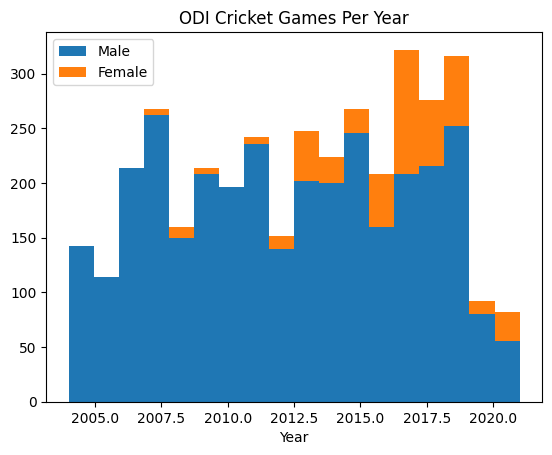

In [4]:
# todo: ask about difference in data set
#       2006 (male), 2009 (female)

print("\nFirst Game Dates (by gender)")
display(match_data.sort_values(by="year").drop_duplicates("gender")[["gender","dates"]])
print()

plt.hist([
    match_data[match_data.gender == "male"].year,
    match_data[match_data.gender == "female"].year
], bins=match_data.year.nunique(), stacked=True, label=["Male", "Female"])

plt.title("ODI Cricket Games Per Year")
plt.xlabel("Year")
plt.legend();

In [5]:
win_data = match_data.groupby(["gender","year","team"])['did_win'].agg(
    total_wins='sum', win_percentage='mean'
).reset_index()

win_data = win_data.sort_values(
    by=["total_wins","win_percentage"], ascending=False
).reset_index(drop=True)

match_data = pd.merge(
    match_data, win_data, on=["gender","year","team"]
)

# save match_results now that all features are added
match_data.to_csv("data/match_results.csv", index=False)

win_data = win_data[win_data.year == 2019]

win_data.head(6)


,gender,year,team,total_wins,win_percentage
14,male,2019,Australia,16,0.695652
22,male,2019,India,15,0.652174
27,male,2019,England,14,0.736842
38,male,2019,New Zealand,13,0.684211
62,female,2019,Australia,10,1.000000
73,male,2019,West Indies,10,0.454545


In [6]:
def print_header(input_header, cur_delim="-"):
    print()
    print(cur_delim * (len(input_header)+2))
    print(" " + input_header)
    print(cur_delim * (len(input_header)+2))

print_header("2019 Cricket Win Stats", "=")

print_header("Highest Win Percentages")
display(
    win_data[win_data.year == 2019].sort_values(by="win_percentage", ascending=False).drop_duplicates(subset="gender").sort_values(by="gender")
)

print_header("Highest Total Wins")
display(
    win_data[win_data.year == 2019].sort_values(by="total_wins", ascending=False).drop_duplicates(subset="gender").sort_values(by="gender")
)



 2019 Cricket Win Stats

-------------------------
 Highest Win Percentages
-------------------------


,gender,year,team,total_wins,win_percentage
62,female,2019,Australia,10,1.0
261,male,2019,Netherlands,1,1.0



--------------------
 Highest Total Wins
--------------------


,gender,year,team,total_wins,win_percentage
62,female,2019,Australia,10,1.000000
14,male,2019,Australia,16,0.695652


---

As observed from the tables above, **Australia** led in both total wins and win percentage in the <u>women</u>'s 2019 season. For the <u>men</u>'s teams, **Australia** had the most wins, while the **Netherlands**, despite playing fewer matches, had the highest win percentage.

This illustrates how total wins and win percentages provide different perspectives on team performance. A team might play fewer matches but win a larger proportion, while another might play more matches, win many, but not most of them. Therefore, for a comprehensive performance evaluation, it's important to consider both these metrics.